# Pseudo batch transformation


## loading fedbatch data

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm

from pseudobatch import pseudobatch_transform, pseudobatch_transform_pandas
from pseudobatch.datasets._dataloaders import _prepare_simulated_dataset

/Users/s143838/.virtualenvs/pseudobatch-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'stan_version_major': '2', 'stan_version_minor': '29', 'stan_version_patch': '2', 'STAN_THREADS': 'false', 'STAN_MPI': 'false', 'STAN_OPENCL': 'false', 'STAN_NO_RANGE_CHECKS': 'false', 'STAN_CPP_OPTIMS': 'false'}


In [2]:
FIGURES_DIR = pathlib.Path('../figures')

In [3]:
# Here we do not use the datasets stored in the package.
# Instead we import the dataset from the article/data folder, 
# this makes sure if the simulations are rerun the new data is used
data_path = pathlib.Path('../data/standard_fed-batch_process.csv')
fedbatch_df = _prepare_simulated_dataset(data_path)

We will make a seperate dataframe that contains on the measurements at the sampling time points.

In [4]:
fedbatch_df_measurements_only = (fedbatch_df
    .query('sample_volume > 0')
    .copy()
    .reset_index(drop=True)
)

We will start by fitting a log-linear model to the non-transformed biomass data in mass units (`m_Biomass`).

$$
log(m_{Biomass}) = a + \mu * t
$$

In [5]:
y, X_noncorrected = dmatrices(formula_like = "np.log(m_Biomass) ~ timestamp", data= fedbatch_df_measurements_only)
model_noncorrected = sm.OLS(endog=y, exog=X_noncorrected)
res_noncorrected = model_noncorrected.fit()
mu_hat_noncorrected = res_noncorrected.params[1]
y_pred_noncorrected = res_noncorrected.predict(X_noncorrected)
print(mu_hat_noncorrected)

0.06597174185227486


The simulated fed-batch culture has a target growth rate of 0.1, thus the estimate based on the non-transformed data is wrong.

# Calculate the growth rate using the pseudo batch transformation

Now we can calculate the corrected biomass using the pseudo batch transformation

In [6]:
fedbatch_df["c_Biomass_pseudo"] = pseudobatch_transform(
    measured_concentration=fedbatch_df["c_Biomass"].to_numpy(),
    reactor_volume=fedbatch_df["v_Volume"].to_numpy(),
    accumulated_feed=fedbatch_df["v_Feed_accum"].to_numpy(),
    concentration_in_feed=0,
    sample_volume=fedbatch_df["sample_volume"].fillna(0).to_numpy(),
)
fedbatch_df_measurements_only["c_Biomass_pseudo"] = pseudobatch_transform(
    measured_concentration=fedbatch_df_measurements_only["c_Biomass"].to_numpy(),
    reactor_volume=fedbatch_df_measurements_only["v_Volume"].to_numpy(),
    accumulated_feed=fedbatch_df_measurements_only["v_Feed_accum"].to_numpy(),
    concentration_in_feed=0,
    sample_volume=fedbatch_df_measurements_only["sample_volume"].fillna(0).to_numpy(),
)

Now we use a linear model to fit the growth rate using the pseudo concentrations.

$$
log(C^{\star}_{Biomass}) = a + \mu * t
$$

In [7]:
y, X_corrected = dmatrices(formula_like = "np.log(c_Biomass_pseudo) ~ timestamp", data= fedbatch_df_measurements_only)
model_corrected = sm.OLS(endog=y, exog=X_corrected)
res_corrected = model_corrected.fit()
mu_hat_corrected = res_corrected.params[1]
print("Fitted growth rate from corrected biomass: " + str(res_corrected.params[1]))

Fitted growth rate from corrected biomass: 0.10000016643815146


The pseudo concentrations and the raw mass measurements are in different numerical scales. This means that when plotted together on the same axis it is not easy to interpret. For visualization purposes we can multiply the pseudo concentrations by the initial reactor volume this scales the pseudo concentrations to a numerical scale that is comparable with the non-transformed mass measurements.

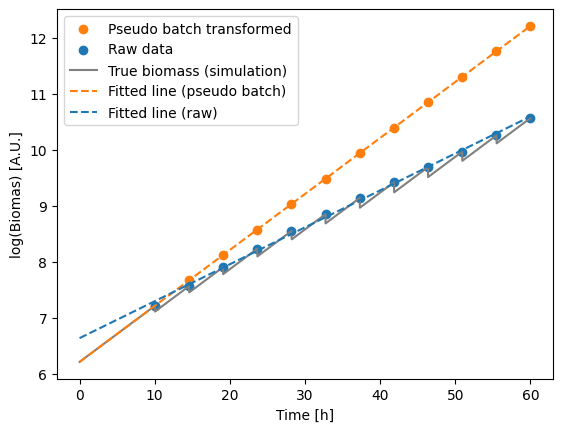

<Figure size 354x354 with 0 Axes>

In [8]:
## plot the data and the fitted line
initial_volume = fedbatch_df_measurements_only["v_Volume"].iloc[0]
plt.scatter(fedbatch_df_measurements_only['timestamp'], fedbatch_df_measurements_only['c_Biomass_pseudo'].multiply(initial_volume).transform(np.log), label='Pseudo batch transformed', color = "C1")
plt.scatter(fedbatch_df_measurements_only['timestamp'], fedbatch_df_measurements_only['m_Biomass'].transform(np.log), label='Raw data', color = "C0")
plt.plot(fedbatch_df['timestamp'], fedbatch_df['m_Biomass'].transform(np.log), label='True biomass (simulation)', color='grey')

# Drawing linear regression line
x_pred = sm.add_constant(fedbatch_df['timestamp']) 
# The model predicts log(c_Biomass_pseudo) and we want to plot log(c_Biomass_pseudo * initial_volume), thus we add log(initial_volume) to the prediction
y_pred_pseudo = res_corrected.predict(x_pred) + np.log(initial_volume) 
y_pred_raw = res_noncorrected.predict(x_pred) 
plt.plot(fedbatch_df['timestamp'], y_pred_pseudo, color='C1', linestyle = 'dashed', label='Fitted line (pseudo batch)')
plt.plot(fedbatch_df['timestamp'], y_pred_raw, color='C0', linestyle = 'dashed', label='Fitted line (raw)')
plt.legend()
plt.ylabel("log(Biomas) [A.U.]")
plt.xlabel("Time [h]")
plt.show()
plt.savefig(FIGURES_DIR / "transformed_and_non-transformed_logscale.png", dpi=300)

# resize height and width of figure
fig = plt.gcf()
fig.set_size_inches((3.54, 3.54))
#fig.legend(bbox_to_anchor=(1.2, 0.5), loc='center right', borderaxespad=0.)
fig.savefig(FIGURES_DIR / "transformed_and_non-transformed_logscale_paper.png", dpi=300)

Finally, we inspect the fitted and true growth rates.

In [9]:
print("Fitted growth rate from pseudo batch transformed biomass: " + str(res_corrected.params[1]))
print("Fitted growth rate from raw biomass: " + str(res_noncorrected.params[1]))
print("True simulated growth rate " + str(fedbatch_df_measurements_only["mu_true"].iloc[-1]))

Fitted growth rate from pseudo batch transformed biomass: 0.10000016643815146
Fitted growth rate from raw biomass: 0.06597174185227486
True simulated growth rate 0.1000104046529978
